In [1]:
import scanpy as sc
import squidpy as sq
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from matplotlib_scalebar.scalebar import ScaleBar
import os

import cell2location
import scvi

DPI = 300
FONTSIZE = 20  # 42
sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

import seaborn as sns
from pathlib import Path

Global seed set to 0


In [2]:
SAMPLE_NAME = "CRC09_LM_VISIUM"

In [3]:
# DIR2SAVE
DIR2SAVE = Path(
    f"/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/{SAMPLE_NAME}"
)
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [4]:
run_name = DIR2SAVE.joinpath(f"cell2location_map-no_cycling_TME/")
run_name.mkdir(parents=True, exist_ok=True)

In [5]:
### cell type signatures
ref_run_name = Path(
    "/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/reference_signatures-noCyclingTME/"
)

### Load visium data

In [6]:
if SAMPLE_NAME == "CRC09_LM_VISIUM":
    adata_vis = sc.read_h5ad(
        f"/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/{SAMPLE_NAME}/{SAMPLE_NAME}_raw_removal_spots.h5ad"
    )

else:
    adata_vis = sc.read_h5ad(
        f"/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/{SAMPLE_NAME}/{SAMPLE_NAME}_raw.h5ad"
    )

In [7]:
set(adata_vis.obs.Sample)

{'CRC09_LM_VISIUM'}

In [8]:
adata_vis.shape

(937, 20471)

### Load cell type signatures estimated 

In [9]:
# The model and output h5ad can be loaded later like this:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File /data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/
         cell2location/reference_signatures-noCyclingTME/model.pt already downloaded         
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/179:   1%|          | 1/179 [00:00<02:45,  1.08it/s, v_num=1, elbo_train=5.13e+8]


In [10]:
adata_ref.shape

(112034, 16744)

### Extracting reference cell types signatures as a pd.DataFrame.

All parameters of the a Negative Binomial regression model are exported into reference anndata object, however for spatial mapping we just need the estimated expression of every gene in every cell type. Here we extract that from standard output:

In [11]:
# export estimated expression in each cluster
if "means_per_cluster_mu_fg" in adata_ref.varm.keys():
    inf_aver = adata_ref.varm["means_per_cluster_mu_fg"][
        [f"means_per_cluster_mu_fg_{i}" for i in adata_ref.uns["mod"]["factor_names"]]
    ].copy()
else:
    inf_aver = adata_ref.var[
        [f"means_per_cluster_mu_fg_{i}" for i in adata_ref.uns["mod"]["factor_names"]]
    ].copy()
inf_aver.columns = adata_ref.uns["mod"]["factor_names"]
inf_aver.iloc[0:5, 0:5]

,B,C1QC Mac,C3 iCAF,CD4 Tfh,CD4 Th
A1BG,0.217940,0.603945,0.482844,0.183307,0.175969
A1CF,0.004003,0.005245,0.064358,0.000937,0.001401
A2M,0.014990,4.373756,1.854340,0.014480,0.021270
A2ML1-AS1,0.001355,0.004277,0.106408,0.000953,0.000283
A4GALT,0.008324,0.006817,0.419700,0.001703,0.000249


#### Compare expected vs real average expression of each gene in each cluster 
* compute mean expression of each gene in each cluster

/tmp/3207258.1.all.q/ipykernel_58343/460581447.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(


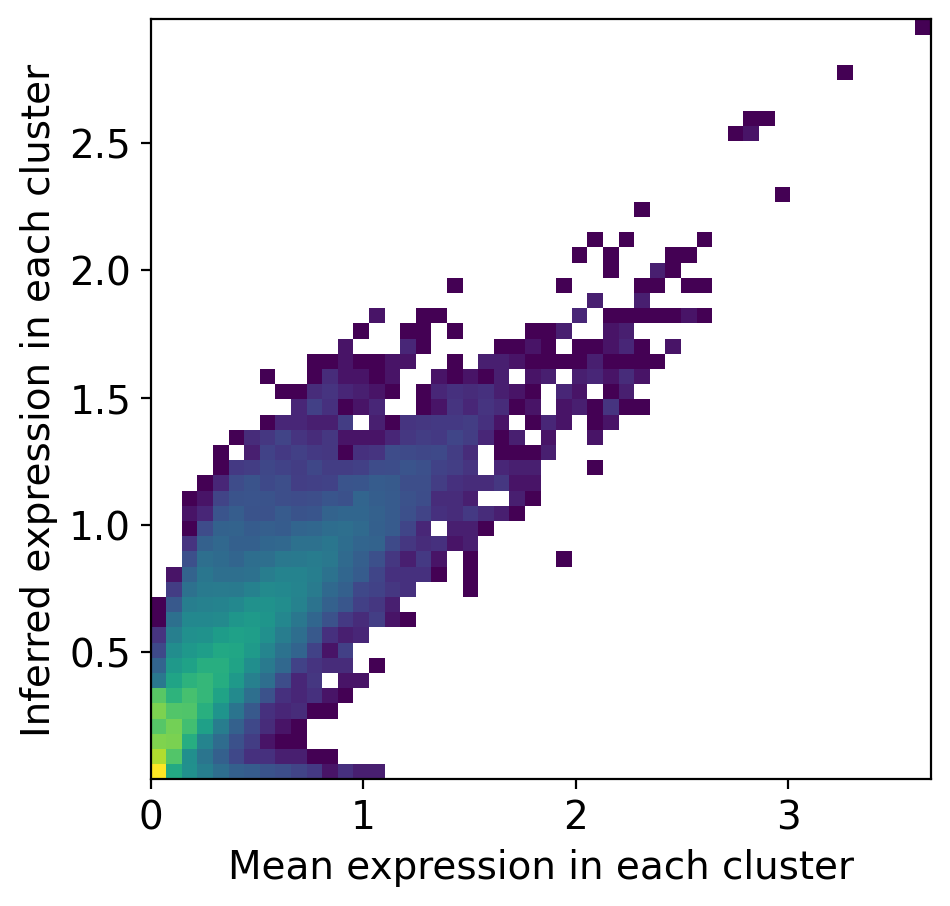

In [12]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.compute_cluster_averages(
    adata_ref,
    "Annotation_scVI_detailed",
    use_raw=False,
)

aver = aver.loc[adata_ref.var_names, inf_aver.columns]

rcParams["figure.figsize"] = 5, 5
plt.hist2d(
    np.log10(aver.values.flatten() + 1),
    np.log10(inf_aver.values.flatten() + 1),
    bins=50,
    norm=mpl.colors.LogNorm(),
)
plt.xlabel("Mean expression in each cluster")
plt.ylabel("Inferred expression in each cluster");

In [13]:
import scipy

scipy.stats.spearmanr(
    np.log10(aver.values.flatten() + 1),
    np.log10(inf_aver.values.flatten() + 1),
    alternative="greater",
)

SpearmanrResult(correlation=0.6827376228178241, pvalue=0.0)

### Cell2location: spatial mapping

NOTE problem with index: gene names are not unique so difficult to map : InvalidIndexError: Reindexing only valid with uniquely valued Index objects. They use ENSEMBL Ids from the beginning but we don't have for the scRNAseq only for Pelka data

In [14]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[
    :, intersect
].copy()  # adata_vis[:, adata_vis.var_names.isin(intersect)].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="Sample")

#### Need to specify 2 user-defined priors/hyperparameters 
* expected cell abundance per location (i.e. spatially defined voxels where transcriptomic
measurements are taken): 
    - given cell size is 10-50µm
    - given location size (spot size) in Visium data is 55 µm 
    - estimated number of cells per location is around 5 
    
The authors mention in suppl. methods that ``In the lymphoid and epithelial tissues,
10X Visium locations contain on average 30 cells and 10 cell types per location reflecting high
spatial interlacing of cell type locations in these tissues``

* regularization of within-experiment variation in RNA detection sensitivity: 

Hyperparameter for regularising within-experiment variation in RNA detectionα𝑦
sensitivity. is the shape parameter of the prior Gamma distribution over that representsα𝑦𝑦𝑠
the extent to which RNA detection sensitivity for individual locations deviates from the mean
sensitivity of each batch. Large values of correspond to small within-experiment variabilityα𝑦
(Suppl. Methods). By default, we assume small within-experiment variability in RNA
detection sensitivity across locations (α=200), which results in values of close to the c𝑦=200𝑦𝑠
mean sensitivity for each experiment. However, when strong gradients in mRNA detection
sensitivity are observed, a common issue in adult human 10X Visium data, we recommend
less strict regularisation (α=20).

To improve accuracy & sensitivity on datasets with large technical variability in RNA detection sensitivity within the slide/batch - you need to relax regularisation of per-location normalisation (use detection_alpha=20). High technical variability in RNA detection sensitivity is present in your sample when you observe the spatial distribution of total RNA count per location that doesn’t match expected cell numbers based on histological examination.

We initially opted for high regularisation (detection_alpha=200) as a default because the mouse brain & human lymph node datasets used in our paper have low technical effects and using high regularisation strenght improves consistencly between total estimated cell abundance per location and the nuclei count quantified from histology (Fig S8F in cell2location paper). However, in many collaborations, we see that Visium experiments on human tissues suffer from technical effects. This motivates the new default value of detection_alpha=20 and the recommendation of testing both settings on your data (detection_alpha=20 and detection_alpha=200).

In [15]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis,
    cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=3,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20,  # 200
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │  937  │
│          n_vars          │ 13816 │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │ CRC09_LM_VISIUM │          0          │
└─────────────────────┴─────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 20000/20000: 100%|██████████| 20000/20000 [21:34<00:00, 15.45it/s, v_num=1, elbo_train=1.22e+7]


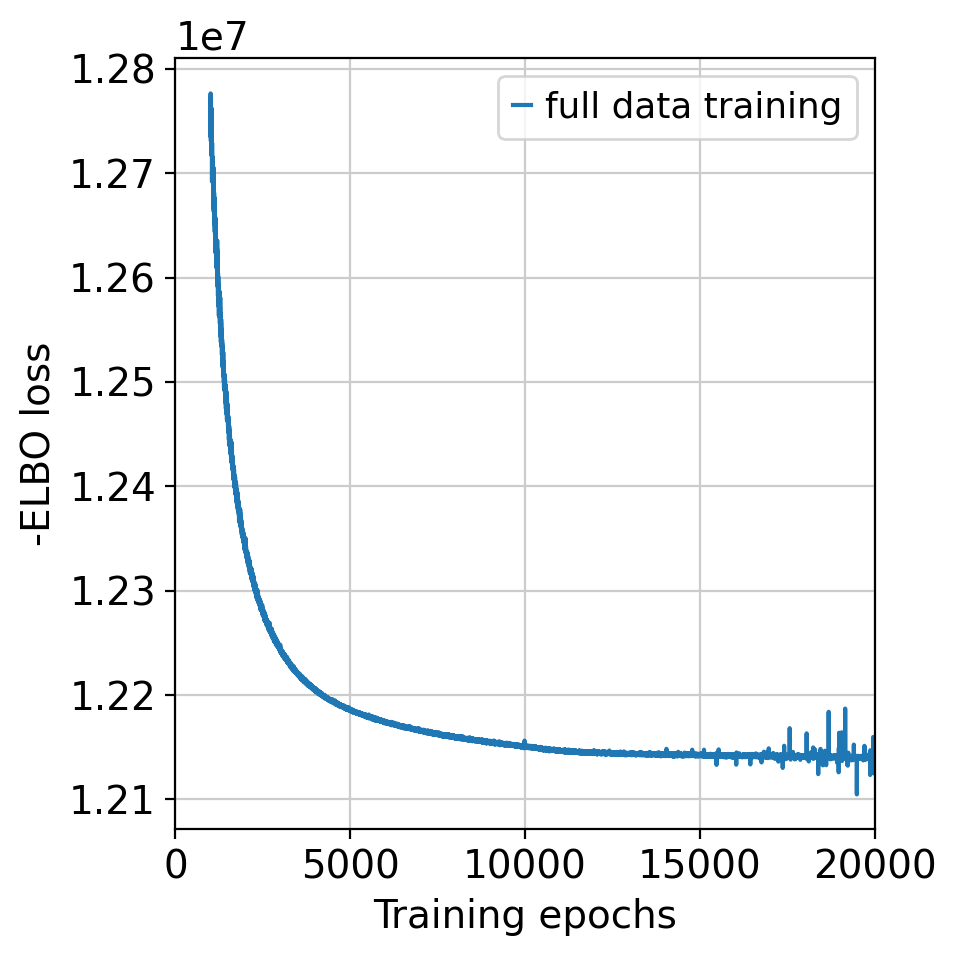

In [16]:
mod.train(
    max_epochs=20000,
    # train using full data (batch_size=None)
    batch_size=None,
    # use all data points in training because
    # we need to estimate cell abundance at all locations
    train_size=1,
    use_gpu=True,
)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=["full data training"]);

Exporting estimated posterior distributions of cell abundance and saving results:

In [17]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis,
    sample_kwargs={"num_samples": 1000, "batch_size": mod.adata.n_obs, "use_gpu": True},
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:14<00:00, 68.86it/s]


'/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/CRC09_LM_VISIUM/cell2location_map-no_cycling_TME/sp.h5ad'

The model and output h5ad can be loaded later like this:

In [18]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File /data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/
         cell2location/CRC09_LM_VISIUM/cell2location_map-no_cycling_TME/model.pt already     
         downloaded                                                                          
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/30000:   0%|          | 1/30000 [00:00<35:44, 13.99it/s, v_num=1, elbo_train=2.18e+7]


Assessing mapping quality. Examine reconstruction accuracy to assess if there are any issues with mapping. The plot should be roughly diagonal, strong deviations will signal problems that need to be investigated.

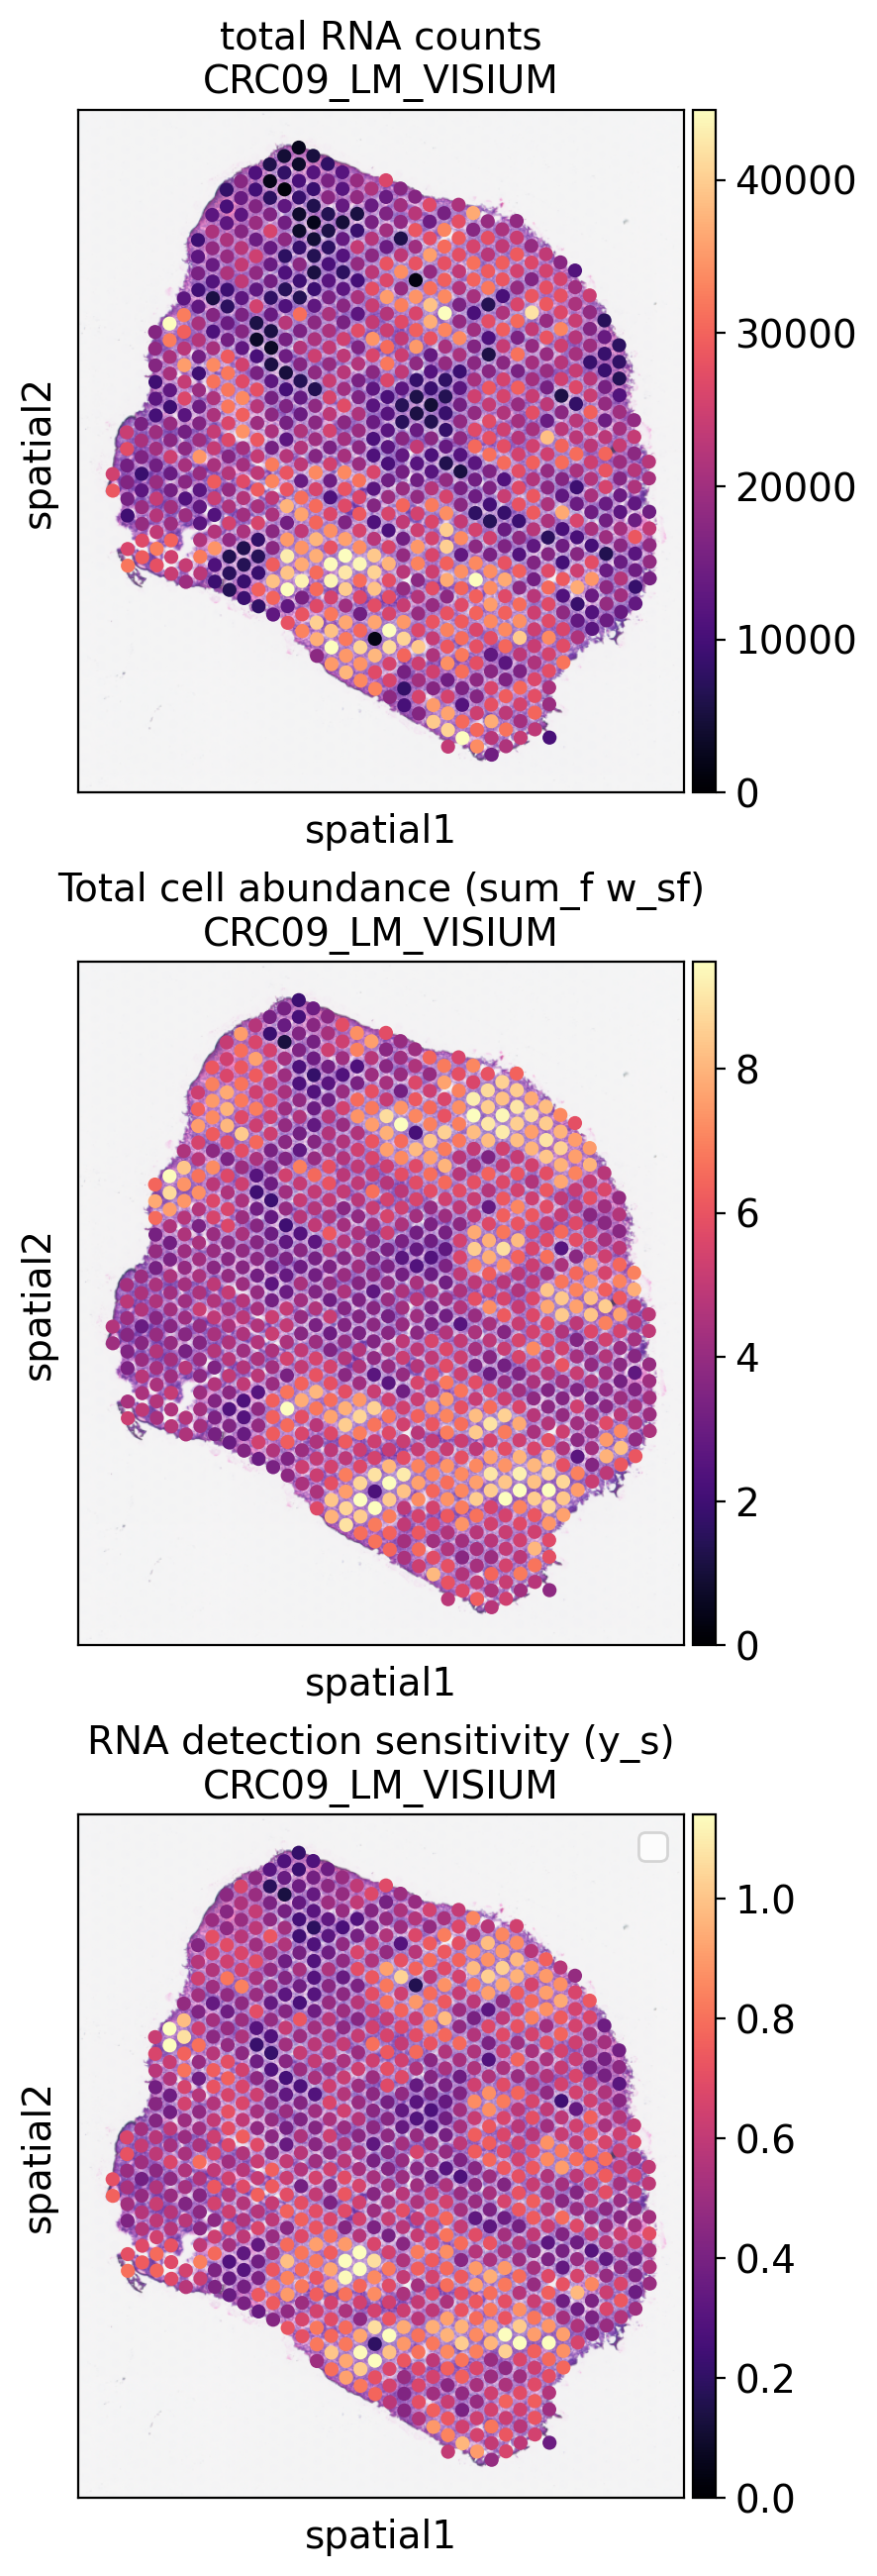

In [19]:
fig = mod.plot_spatial_QC_across_batches()
plt.legend(labels=["full data training"]);
plt.savefig(
        f"{run_name}/mapping_quality.png", bbox_inches="tight"
    )
plt.show()
plt.close()

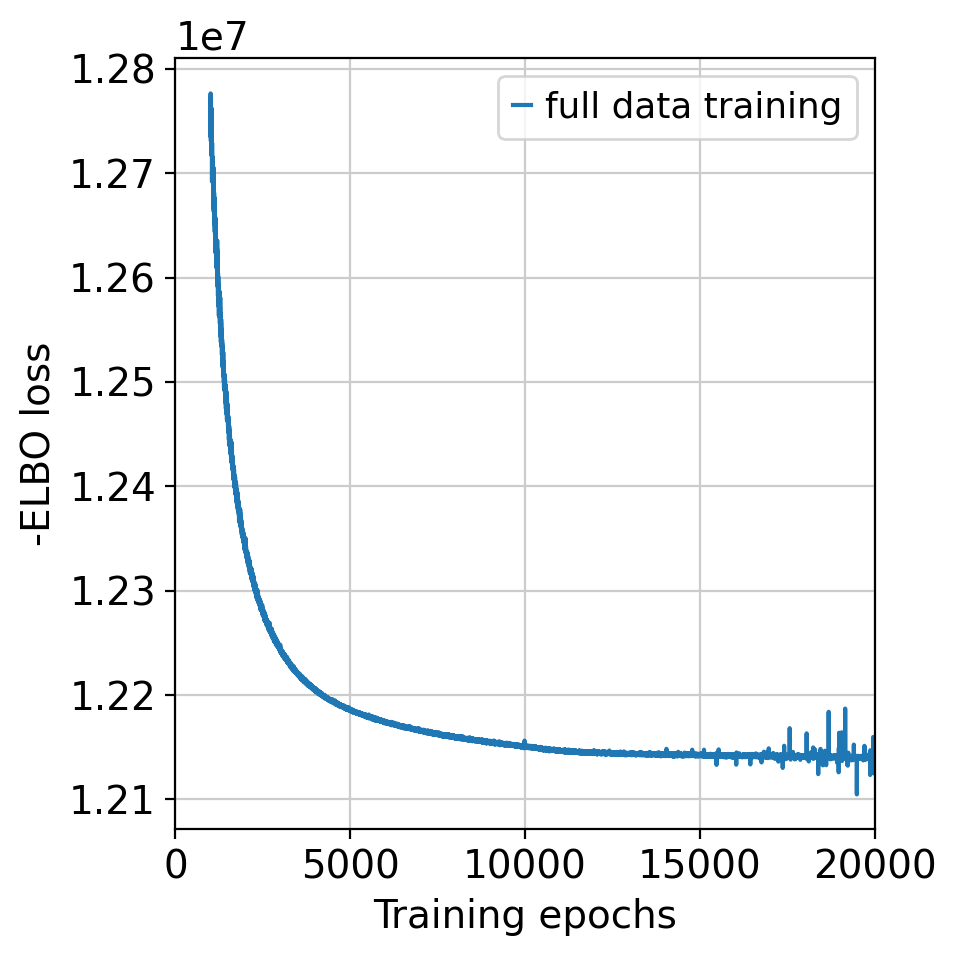

In [20]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=["full data training"]);
plt.savefig(
        f"{run_name}/elbow.png", bbox_inches="tight"
    )
plt.show()
plt.close()

### the reconstruction accuracy
how well reference cell type signatures explain spatial data by comparing expected value of the model μs,g (Negative Binomial mean) to observed count of each gene across locations. The ideal case is a perfect diagonal 2D histogram plot (across genes and locations).


In [21]:
mod.export_posterior(
    adata_vis,
    sample_kwargs={"num_samples": 1000, "batch_size": mod.adata.n_obs, "use_gpu": True},
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:14<00:00, 68.79it/s]


AnnData object with n_obs × n_vars = 937 × 13816
    obs: 'in_tissue', 'array_row', 'array_col', 'Sample', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_indices', '_scvi_batch', '_scvi_labels', 'total RNA counts', 'Total cell abundance (sum_f w_sf)', 'RNA detection sensitivity (y_s)'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'means_cell_abundance_w_sf', 'mt', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'ribo', 'segmentation_features', 'spatial', 'stds_cell_abundance_w_sf'

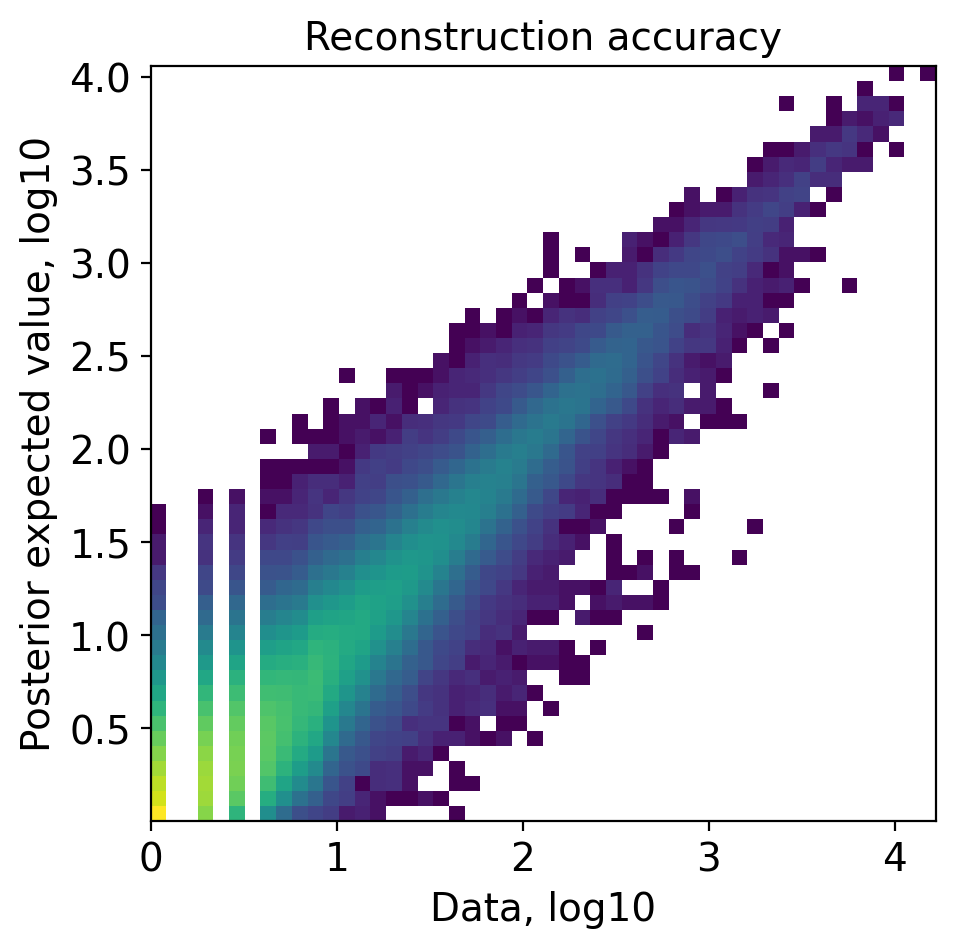

In [22]:
if True:
    mod.plot_QC(summary_name="means")
    plt.savefig(
        f"{run_name}/reconstruction_accuracy_histogram.png", bbox_inches="tight"
    )
    plt.show()
    plt.close()

In [23]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File /data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/
         cell2location/CRC09_LM_VISIUM/cell2location_map-no_cycling_TME/model.pt already     
         downloaded                                                                          
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/30000:   0%|          | 1/30000 [00:00<38:27, 13.00it/s, v_num=1, elbo_train=2.17e+7]
